In [2]:
import os
import itertools
import glob
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.autograd import Variable

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print("학습 데이터셋 A의 개수:", len(next(os.walk('./dataset/horse2zebra/trainA/'))[2]))
print("학습 데이터셋 B의 개수:", len(next(os.walk('./dataset/horse2zebra/trainB/'))[2]))
print("테스트 데이터셋 A의 개수:", len(next(os.walk('./dataset/horse2zebra/testA/'))[2]))
print("테스트 데이터셋 B의 개수:", len(next(os.walk('./dataset/horse2zebra/testB/'))[2]))

학습 데이터셋 A의 개수: 1067
학습 데이터셋 B의 개수: 1334
테스트 데이터셋 A의 개수: 120
테스트 데이터셋 B의 개수: 140


이미지 크기: (256, 256)


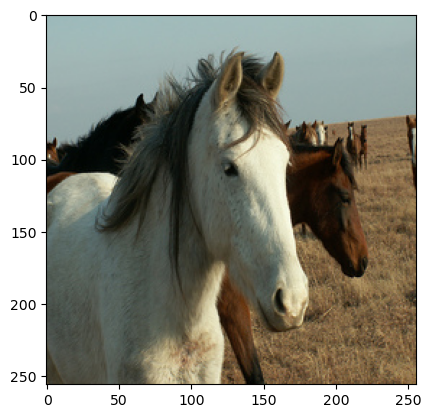

In [4]:
# 한 쌍의 이미지 출력(왼쪽은 정답 이미지, 오른쪽은 조건 이미지)
image = Image.open('./dataset/horse2zebra/trainA/n02381460_11.jpg')
print("이미지 크기:", image.size)

plt.imshow(image)
plt.show()

In [16]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None,unaligned=False, mode="train"):
        self.transform = transforms_
        self.unaligned = unaligned
        
        self.files_A = sorted(glob.glob(os.path.join(root, 'trainA') +"/*.jpg"))
        self.files_B = sorted(glob.glob(os.path.join(root, 'trainB') +"/*.jpg"))
        if mode == "train":
            self.files_A.extend(sorted(glob.glob(os.path.join(root, "testA") + "/*.jpg"))) #extend: iterable의 각 요소들을 추가해줌
            self.files_B.extend(sorted(glob.glob(os.path.join(root, "testB") + "/*.jpg")))
    
    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))

        if self.unaligned:
            item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]))
        else:
            item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]))

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [17]:
transforms_ = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))      # 각채널별로 mean.std값 부여
])


In [18]:
train_dataset = ImageDataset("./dataset/horse2zebra/", transforms_=transforms_)
val_dataset = ImageDataset("./dataset/horse2zebra/", transforms_=transforms_)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [19]:
len(train_dataset)

1474

In [20]:
for i, batch in enumerate(train_dataloader):
        # Set model input
        real_A = batch["A"].cuda()    #horse
        real_B = batch["B"].cuda()    #zebra
        print(real_A.shape)

torch.Size([64, 3, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 3, 256, 256])


RuntimeError: output with shape [1, 256, 256] doesn't match the broadcast shape [3, 256, 256]

# 모델 정의

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)


In [8]:
class Generator(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block       
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


In [9]:
class Discriminator(nn.Module):
    def __init__(self, input_nc=3):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        model = [   nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(256, 512, 4, padding=1),
                    nn.InstanceNorm2d(512), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        # FCN classification layer
        model += [nn.ZeroPad2d((1, 0, 1, 0))]
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1) #마지막에 patch를 보는게 아니라 avgpool(flatten)값을 본다?

# 모델 학습 디테일?

In [10]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [11]:
class ReplayBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

In [12]:
def tensor2image(tensor):
    image = 127.5*(tensor[0].cpu().float().numpy() + 1.0)
    if image.shape[0] == 1:
        image = np.tile(image, (3,1,1))
    return image.astype(np.uint8)

In [13]:
# 생성자(generator)와 판별자(discriminator) 초기화
netG_A2B = Generator()
netG_B2A = Generator()
netD_A = Discriminator()
netD_B = Discriminator()

netG_A2B.cuda()
netG_B2A.cuda()
netD_A.cuda()
netD_B.cuda()

# 가중치(weights) 초기화
netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

# 손실 함수(loss function)
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

#sdf
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# 학습률(learning rate) 설정
lr = 0.0002

# Optimizers & LR schedulers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr, betas=(0.5, 0.999))

In [14]:
###### Training ######
import time

n_epochs = 200 # 학습의 횟수(epoch) 설정
sample_interval = 200 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정

# 변환된 이미지와 정답 이미지 사이의 L1 픽셀 단위(pixel-wise) 손실 가중치(weight) 파라미터
lambda_pixel = 100

start_time = time.time()

for epoch in range(n_epochs):
    for i, batch in enumerate(train_dataloader):
        # Set model input
        real_A = batch["A"].cuda()    #horse
        real_B = batch["B"].cuda()    #zebra
        
        target_real = torch.cuda.FloatTensor(real_A.size(0), 1, 16, 16).fill_(1.0) # 진짜(real): 1
        target_fake = torch.cuda.FloatTensor(real_A.size(0), 1, 16, 16).fill_(0.0) # 가짜(fake): 0

        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()

        # Identity loss
        # G_A2B(B) should equal B if real B is fed
        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B)*5.0
        # G_B2A(A) should equal A if real A is fed
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A)*5.0

        # GAN loss
        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

        # Cycle loss
        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0

        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0

        # Total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        
        optimizer_G.step()
        ###################################

        ###### Discriminator A ######
        optimizer_D_A.zero_grad()

        # Real loss
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake loss
        fake_A = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()

        optimizer_D_A.step()
        ###################################

        ###### Discriminator B ######
        optimizer_D_B.zero_grad()

        # Real loss
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, target_real)
        
        # Fake loss
        fake_B = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        loss_D_B.backward()

        optimizer_D_B.step()
        ###################################
        
        done = epoch * len(train_dataloader) + i
        if done % sample_interval == 0:
            imgs = next(iter(train_dataloader)) # 10개의 이미지를 추출해 생성
            real_A = imgs["A"].cuda()
            real_B = imgs["B"].cuda()
            fake_B = netG_A2B(real_A)
            fake_A = netG_B2A(real_B)
            # real_A: 조건(condition), fake_B: 변환된 이미지(translated image), real_B: 정답 이미지
            img_sample = torch.cat((fake_A.data, fake_B.data), -2) # 높이(height)를 기준으로 이미지를 연결하기
            save_image(img_sample, f"{done}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D_B loss: {loss_D_B.item():.6f}][D_A loss: {loss_D_A.item():.6f}] [G loss: {loss_G.item():.6f}]")

C:\Users\anykk\anaconda3\envs\pytorch1\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([4, 1, 16, 16])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (4) must match the size of tensor b (16) at non-singleton dimension 2

In [ ]:
len(train_dataloader)